In [39]:
%load_ext autoreload
%autoreload 1
%aimport environment

from environment import CarEnv

import numpy as np

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
env = CarEnv(0, False)
print(env.observation_space.shape) # size of the image
print(env.action_space) 
action_dim = 6

(84, 84, 3)
Discrete(4)


In [45]:
print( CarEnv(30, False).observation_space.shape)

(84, 84, 3)


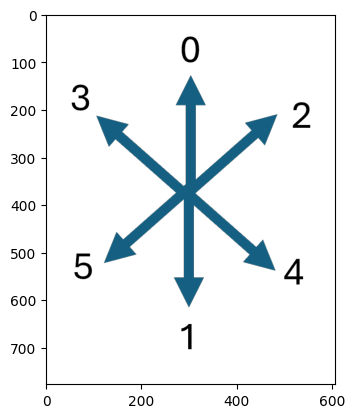

In [15]:
img = plt.imread("action space.png")
plt.imshow(img)

### test

In [16]:
# Create an instance of the custom environment
env = CarEnv(5)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: 32.21185479296481


In [17]:
env = CarEnv(10,False)
obs = env.reset()


Discrete(4)
0.4166770187222738


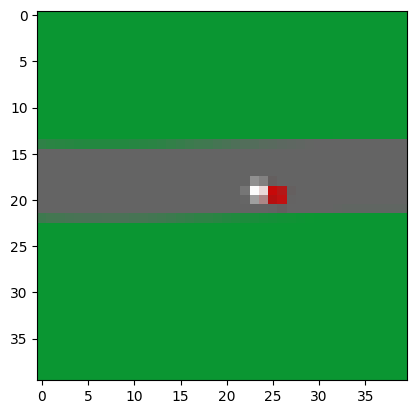

In [58]:
# Size of the image is reduced to make training faster
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

### DL models

In [19]:
import torch
import pandas as pd
import seaborn as sns

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
from deep_Q_newtork import QNetwork, OtherQNetwork, EpsilonGreedy, MinimumExponentialLR, ReplayBuffer, DQNAgent

In [65]:
obstensor = CarEnv.obs2tensor(obs, device)
model = QNetwork(action_dim).to(device)

model(obstensor)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1600 and 2304x32)

In [ ]:
env = CarEnv(30, False)

NUMBER_OF_TRAININGS = 1
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)

    optimizer = torch.optim.AdamW(
        q_network.parameters(), lr=0.004, amsgrad=True)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(
        optimizer, lr_decay=0.99, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network
    dqn_agent = DQNAgent(env=env,
                         q_network=q_network,
                         target_q_network=target_q_network,
                         target_q_network_sync_period=50,
                         device=device,
                         gamma=0.85,
                         delay=4,
                         replay_buffer=replay_buffer
                         )

    episode_reward_list = dqn_agent.train(num_episodes=300,
                                          batch_size=128,
                                          loss_fn=loss_fn,
                                          epsilon_greedy=epsilon_greedy,
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          )
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend(
        [train_index for _ in episode_reward_list])

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1600 and 2304x32)

In [ ]:
episode_reward_list = train_dqn2_agent(env,
                                        q_network,
                                        target_q_network,
                                        optimizer,
                                        loss_fn,
                                        epsilon_greedy,
                                        device,
                                        lr_scheduler,
                                        num_episodes=300,
                                        gamma=0.9,
                                        batch_size=128,
                                        replay_buffer=replay_buffer,
                                        target_q_network_sync_period=30,
                                        delay = 2)
dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
dqn2_trains_result_list[1].extend(episode_reward_list)
dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

NameError: name 'train_dqn2_agent' is not defined

In [ ]:
env.close()

In [ ]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

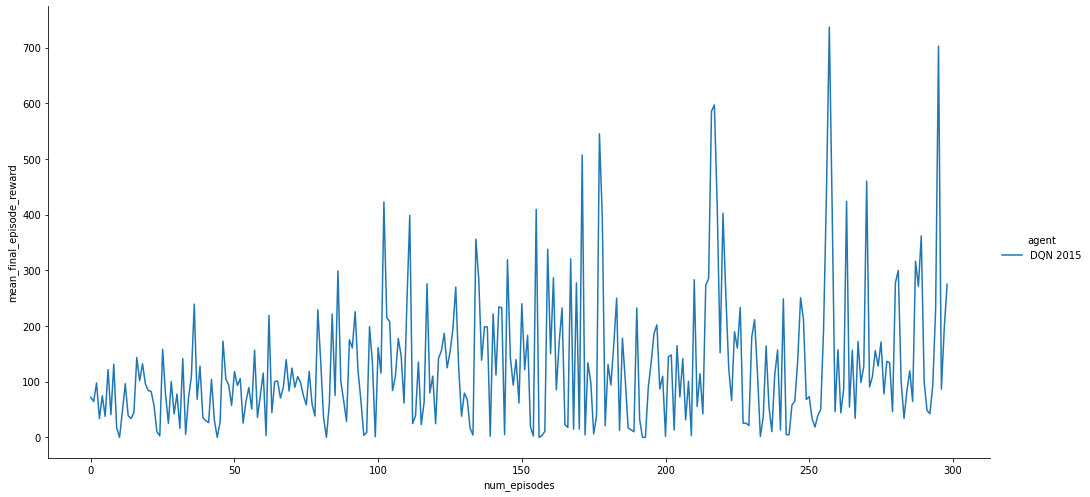

In [ ]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
                height=7, aspect=2);

In [31]:
# q_network = torch.load("dqn2_q_network.pth")
other_q_network = torch.load("dqn2_otherq_network.pth")

In [68]:
# Create an instance of the custom environment
env = CarEnv(300,evaluation=True)

# Example of using the environment
obs = env.reset()
score = 0

while True:
    obstensor = CarEnv.obs2tensor(obs, device)
    # action = q_network(obstensor).argmax(dim=1)
    action = other_q_network(obstensor).argmax(dim=1)
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
print(score)

28.16260648914151
